In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pySAMetrics
import matplotlib.pyplot as plt
from pySAMetrics.Simulation import Simulation
from pySAMetrics.utils import generate_simulation_paths
from tqdm import tqdm

In [3]:
!hostname -i

172.31.12.134


In [4]:
simu_list=[]

### add control case
# Example usage
velocity = '0'
temperature='300'
bowen_ratio='1'
microphysic='1'

paths = generate_simulation_paths(velocity=velocity, temperature=temperature, bowen_ratio=bowen_ratio, microphysic=microphysic, folder_path='/home/ec2-user/DeepCloudLab/outputs')

print(paths)

simu = Simulation(data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
                velocity=velocity,
                temperature=temperature,
                bowen_ratio=bowen_ratio,
                microphysic=microphysic)

simu.load(backup_folder_path='/home/ec2-user/DeepCloudLab/processed_classes')
simu_list.append(simu)


### add shear cases
for velocity in tqdm(['2.5']):#, '5', '10', '20']):
    temperature='300'
    bowen_ratio='1'
    microphysic='1'

    paths = generate_simulation_paths(velocity=velocity, temperature=temperature, bowen_ratio=bowen_ratio, microphysic=microphysic, folder_path='/home/ec2-user/DeepCloudLab/outputs')

    print(paths)

    simu = Simulation(data_folder_paths=[paths['path_1d'], paths['path_2d'], paths['path_3d']],
                    velocity=velocity,
                    temperature=temperature,
                    bowen_ratio=bowen_ratio,
                    microphysic=microphysic)

    simu.load(backup_folder_path='/home/ec2-user/DeepCloudLab/processed_classes')
    simu_list.append(simu)



{'path_3d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U0_B1_M1/WORK/NETCDF_files/3D/dataset_3d.nc', 'path_2d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U0_B1_M1/WORK/NETCDF_files/2D/RCE_T300_U0_SAM1MOM_B1_128x128x64_64.2Dcom_1.nc', 'path_1d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U0_B1_M1/WORK/NETCDF_files/1D/RCE_T300_U0_SAM1MOM_B1_128x128x64.nc'}


****/home/ec2-user/DeepCloudLab/processed_classes/RCE_T300_U0_B1_M1


  0%|          | 0/1 [00:00<?, ?it/s]

{'path_3d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U2.5_B1_M1/WORK/NETCDF_files/3D/dataset_3d.nc', 'path_2d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U2.5_B1_M1/WORK/NETCDF_files/2D/RCE_T300_U2.5_SAM1MOM_B1_128x128x64_64.2Dcom_1.nc', 'path_1d': '/home/ec2-user/DeepCloudLab/outputs/RCE_T300_U2.5_B1_M1/WORK/NETCDF_files/1D/RCE_T300_U2.5_SAM1MOM_B1_128x128x64.nc'}


100%|██████████| 1/1 [00:17<00:00, 17.63s/it]

****/home/ec2-user/DeepCloudLab/processed_classes/RCE_T300_U2.5_B1_M1


In [5]:
[simu.name for simu in simu_list]

['RCE_T300_U0_B1_M1', 'RCE_T300_U2.5_B1_M1']

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import ticker

Explained variance ratio: [0.06680266 0.02313765 0.01774649]
Principal components shape: (3, 3200)


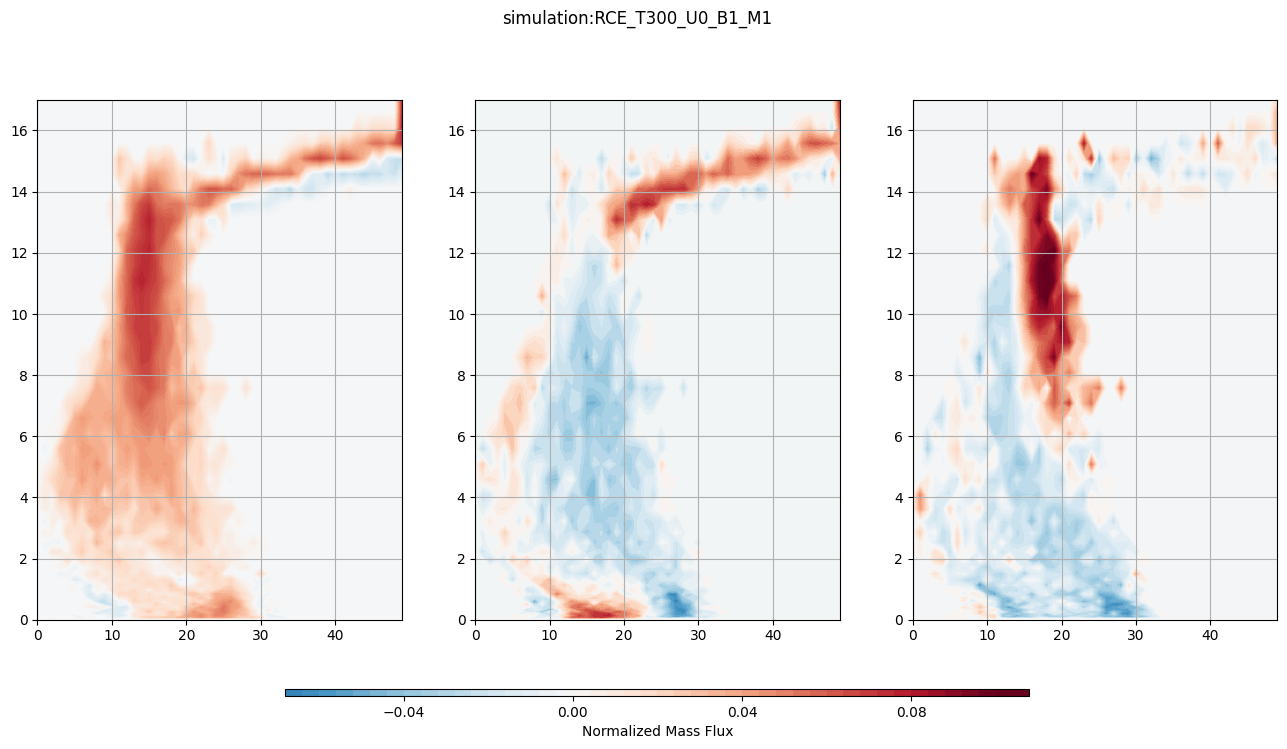

In [7]:
fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,YY = np.meshgrid(fmse, z)

RHO_W = simu_list[0].dataset_isentropic.RHO_W.values

# Assuming RHO_W is your 3D variable with shape (nt, n_x, n_y)
# Step 1: Replace NaN values with -10
RHO_W_clean = np.nan_to_num(RHO_W, nan=0)

# Step 2: Reshape the data from (nt, n_x, n_y) to (nt, n_x * n_y)
nt, n_x, n_y = RHO_W_clean.shape
reshaped_RHO_W = RHO_W_clean.reshape(nt, n_x * n_y)

# Step 3: Standardize the data (mean = 0, variance = 1)
scaler = StandardScaler()
standardized_RHO_W = scaler.fit_transform(reshaped_RHO_W)

# Step 4: Apply PCA
n_components = 3  # Set the number of principal components you want to keep
pca_control = PCA(n_components=n_components)
pca_result_control = pca_control.fit_transform(standardized_RHO_W)

# Access PCA results:
explained_variance_ratio = pca_control.explained_variance_ratio_
principal_components = pca_control.components_

# Outputs:
print("Explained variance ratio:", explained_variance_ratio)
print("Principal components shape:", principal_components.shape)

fig, ax = plt.subplots(1,n_components, figsize=(16,9))
# Step 5: Visualize the spatial modes (only for valid points)
for i in range(n_components):
    # Create an empty grid and fill valid points
    #spatial_mode = np.zeros((n_x, n_y))*np.nan
    spatial_mode = pca_control.components_[i].reshape(n_x, n_y)

    #print(np.min(pca.components_[i]), print(np.max(pca.components_[i])))


    im = ax[i].contourf(XX,YY, spatial_mode, 50, cmap='RdBu_r', vmin=-0.1,vmax = 0.1 )
    ax[i].grid(True)

    #ax[i].set_title(f'explained variance: {pca.explained_variance_ratio_[i]}')
    ax[i].set_ylim(0,17)

fig.suptitle(f'simulation:{simu_list[0].name}')
cb = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.6, aspect=110, pad=0.1, label='Normalized Mass Flux')
#cb = plt.colorbar(im, shrink=0.6, orientation='horizontal')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

    #plt.show()

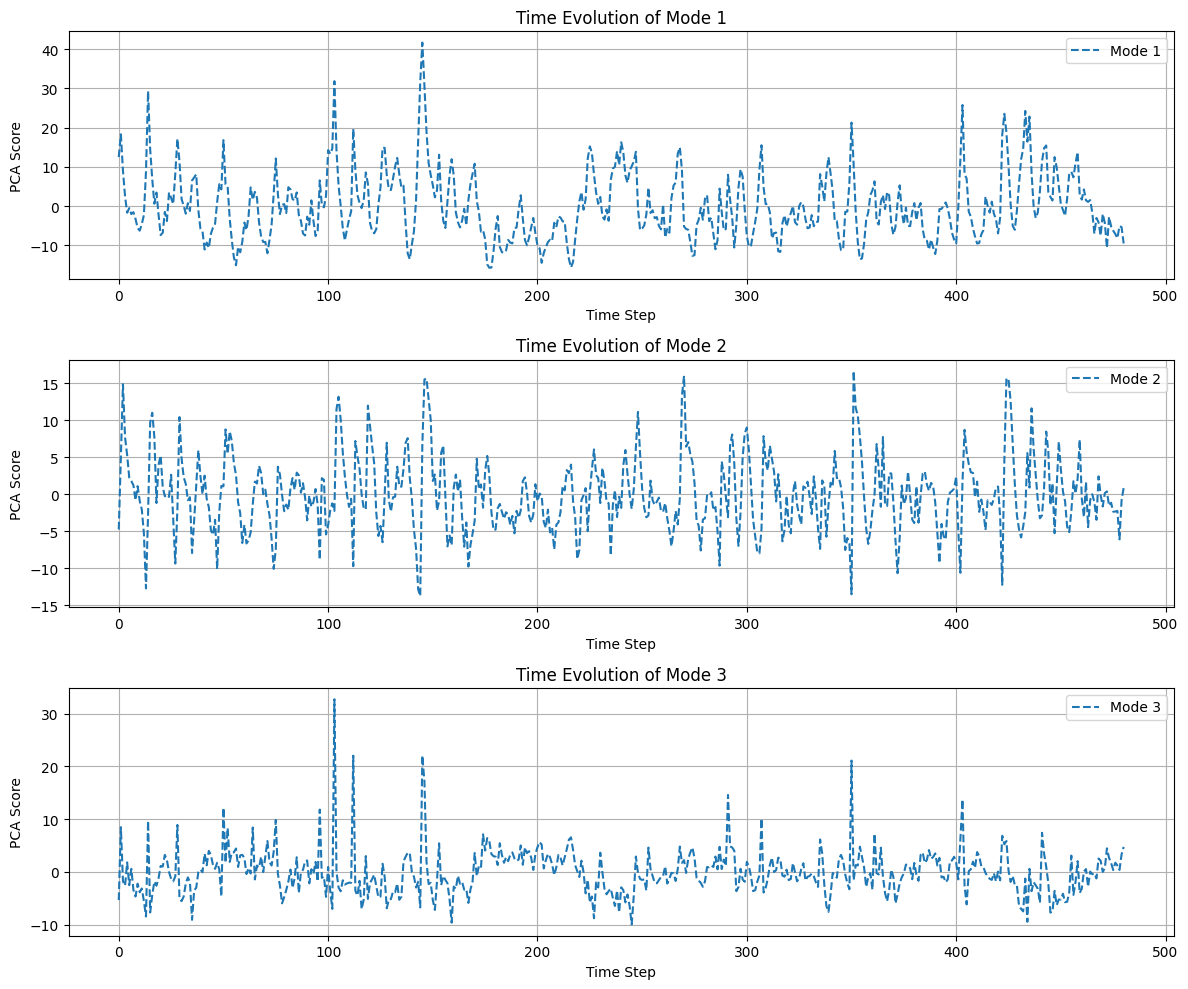

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pca_result is the result of the PCA, which has shape (nt, n_components)
# Where nt is the number of timesteps, and n_components is the number of PCA modes

# Step 1: Get PCA scores (time evolution of modes)
# pca_result is already your PCA scores, as we computed before.

# Step 2: Plot the time evolution of each PCA mode
n_components = pca_result_control.shape[1]  # Number of PCA components

plt.figure(figsize=(12, 10))
for i in range(n_components):
    plt.subplot(n_components, 1, i + 1)  # Create a subplot for each component
    plt.plot(pca_result_control[:, i], label=f'Mode {i + 1}', color=simu_list[0].color, ls='--')  # Plot scores over time
    plt.title(f'Time Evolution of Mode {i + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('PCA Score')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


In [9]:
[simu.name for simu in simu_list]

['RCE_T300_U0_B1_M1', 'RCE_T300_U2.5_B1_M1']

In [13]:
array_isentropic_all=[]

for i, simu in enumerate(simu_list):
    new_variable = simu.dataset_isentropic.RHO_W.values  # Extract the new variabl
    array_isentropic_all.append(new_variable)

array_isentropic_all=np.array(array_isentropic_all)
reshaped_data = array_isentropic_all.reshape(-1, 64, 50)


In [14]:
reshaped_data = np.nan_to_num(reshaped_data)
mean_norm_data, std_norm_data = reshaped_data.mean(), reshaped_data.std()
print('mean', 'std', reshaped_data.mean(), reshaped_data.std())
reshaped_data = (reshaped_data - reshaped_data.mean()) / reshaped_data.std()  # Normalize data
reshaped_data = reshaped_data.reshape((reshaped_data.shape[0], -1))


mean std 0.5295836408742808 1.5313830478817303


/tmp/ipykernel_58003/486839365.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


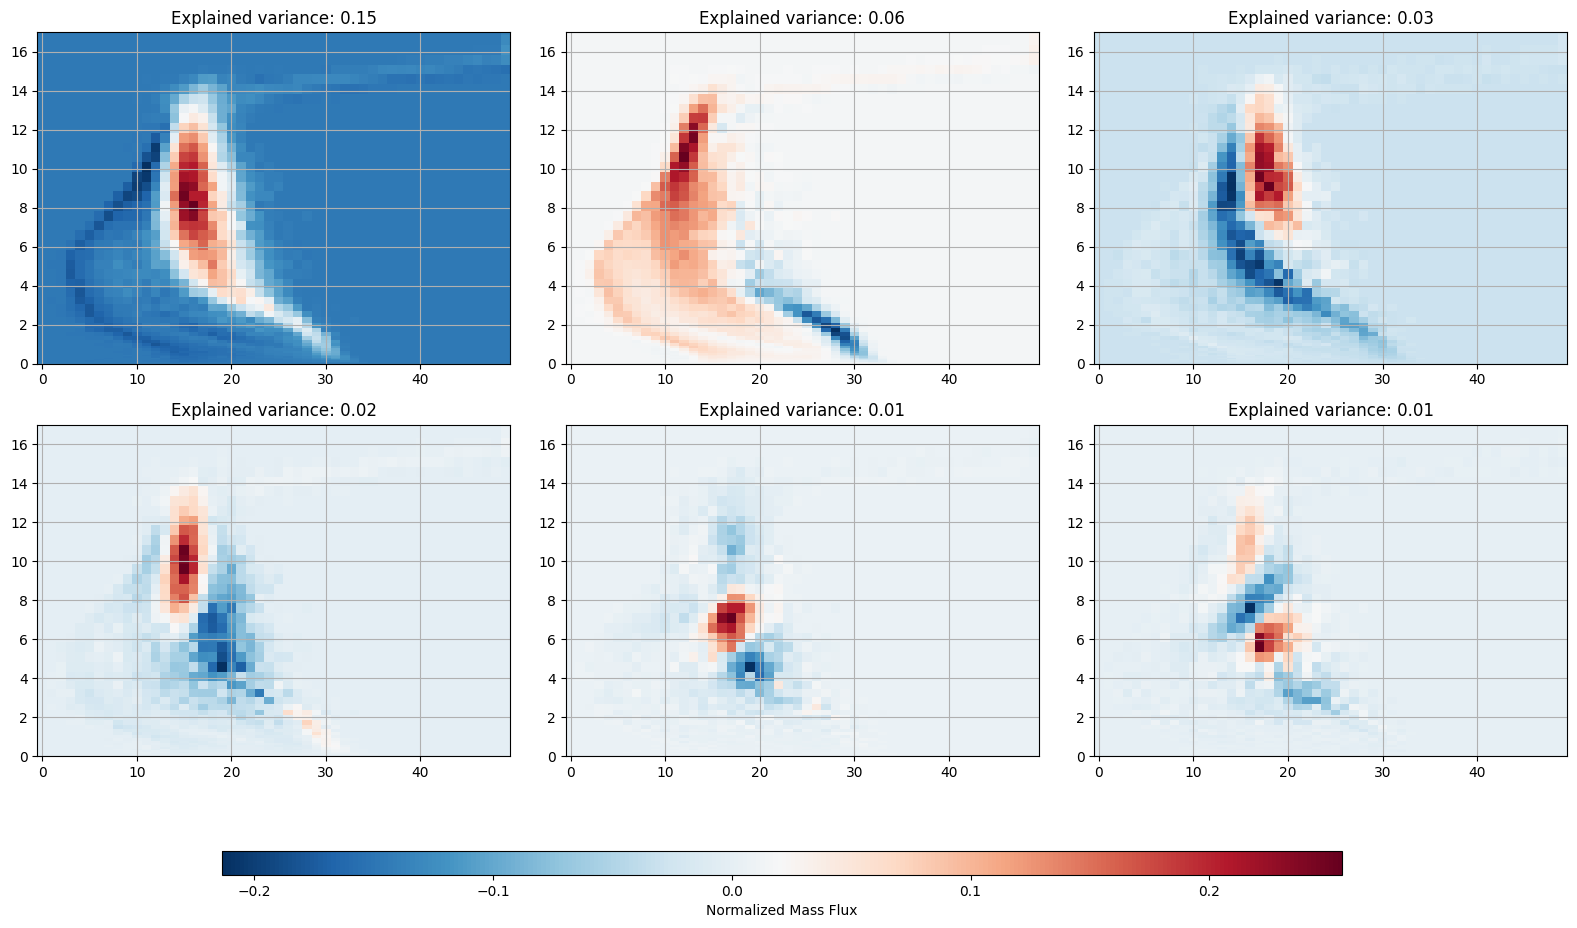

In [15]:
import math
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

n_x, n_y = 64, 50

# Step 4: Apply PCA
n_components = 6
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(reshaped_data)

# Access PCA results:
explained_variance_ratio = pca.explained_variance_ratio_
principal_components = pca.components_

# Determine the number of rows and columns (maximum 3 plots per row)
max_cols = 3
n_rows = math.ceil(n_components / max_cols)

# Create the subplots with the appropriate grid size
fig, axes = plt.subplots(n_rows, max_cols, figsize=(16, n_rows * 4))

# If we have only one row, turn axes into a 1D array
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)

# Step 5: Visualize the spatial modes (only for valid points)
for i in range(n_components):
    # Calculate which row and column the current plot should go into
    row = i // max_cols
    col = i % max_cols
    
    # Create an empty grid and fill valid points
    spatial_mode = principal_components[i].reshape(n_x, n_y)

    # Plot the contour on the correct axis
    #im = axes[row, col].contourf(XX, YY, spatial_mode, 50, cmap='RdBu_r')
    im = axes[row, col].pcolormesh(XX, YY, spatial_mode, cmap='RdBu_r')

    axes[row, col].grid(True)
    axes[row, col].set_ylim(0, 17)
    axes[row, col].set_title(f'Explained variance: {explained_variance_ratio[i]:.2f}')

# Hide any unused subplots
for j in range(n_components, n_rows * max_cols):
    fig.delaxes(axes.flatten()[j])

# Add colorbar outside the plot (below)
fig.subplots_adjust(bottom=0.2)  # Adjust the space at the bottom for the colorbar
cbar_ax = fig.add_axes([0.15, -0.1, 0.7, 0.03])  # [left, bottom, width, height]
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', aspect=110, shrink=0.5, pad=10)
cb.set_label('Normalized Mass Flux')

# Optionally adjust tick locator
#tick_locator = ticker.MaxNLocator(nbins=5)
#cb.locator = tick_locator
#cb.update_ticks()

plt.tight_layout()
plt.show()


In [67]:
pca.components_[i].shape

(3200,)

100%|██████████| 2/2 [00:00<00:00, 21.17it/s]


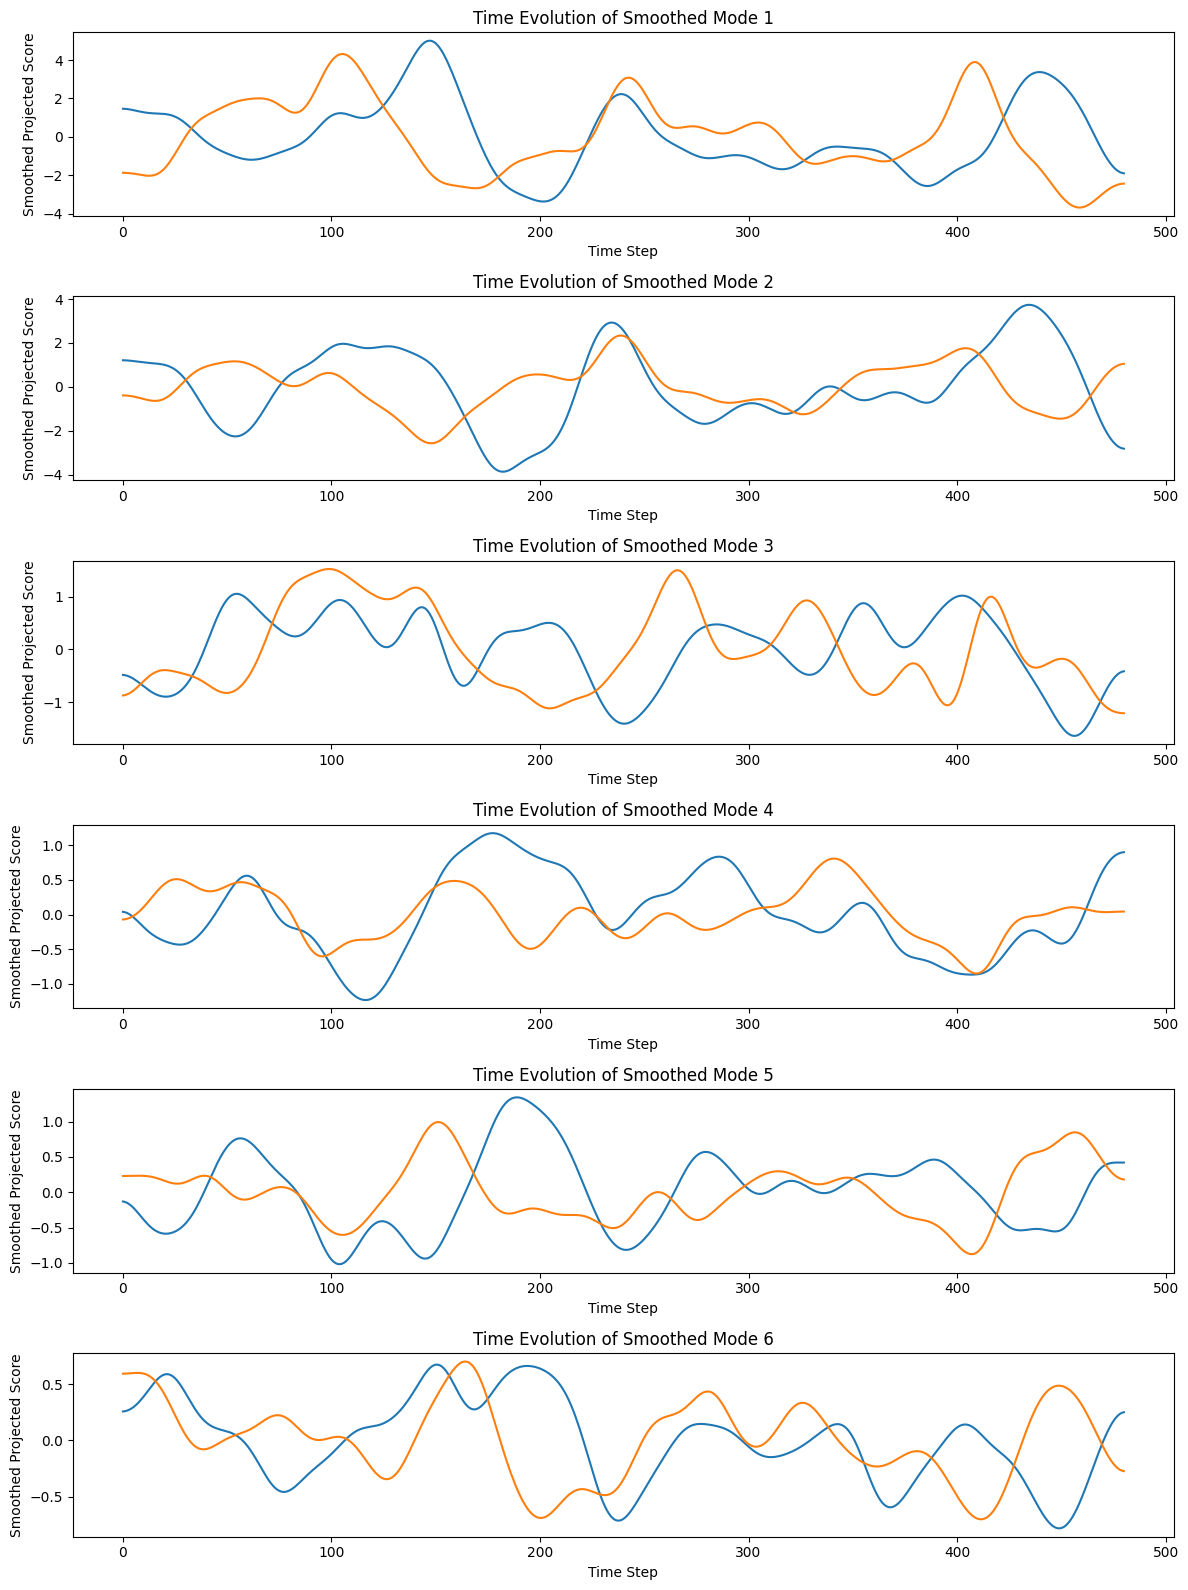

In [68]:
from scipy.ndimage import gaussian_filter1d
smoothing_sigma = 10

fig, ax = plt.subplots(n_components, 1, figsize=(12, 16))

for i_simu in tqdm(range(2)):
    RHO_W_new = simu_list[i_simu].dataset_isentropic.RHO_W.values

    # Step 1: Replace NaN values with 0 (or another value depending on your preference)
    RHO_W_clean_new = np.nan_to_num(RHO_W_new, nan=0)

    # Step 2: Reshape the data from (nt, n_x, n_y) to (nt, n_x * n_y)
    nt, n_x, n_y = RHO_W_clean_new.shape
    reshaped_RHO_W_new = RHO_W_clean_new.reshape(nt, n_x * n_y)

    # Step 3: Standardize the data (mean = 0, variance = 1)
    scaler = StandardScaler()
    standardized_RHO_W_new = scaler.fit_transform(reshaped_RHO_W_new)

    # Step 4: Project the new data onto the PCA components
    projected_scores = standardized_RHO_W_new.dot(pca.components_.T)  # Shape: (nt, n_components)

    # Step 5: Apply smoothing to the time series using Gaussian filter
    smoothed_scores = gaussian_filter1d(projected_scores, sigma=smoothing_sigma, axis=0)

    # Step 6: Plot the time evolution of the smoothed data
    for i in range(n_components):
        ax[i].plot(smoothed_scores[:, i], label=f'Mode {i + 1}')
        ax[i].grid()
        ax[i].set_title(f'Time Evolution of Smoothed Mode {i + 1}')
        ax[i].set_xlabel('Time Step')
        ax[i].set_ylabel('Smoothed Projected Score')

plt.tight_layout()
plt.show()


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


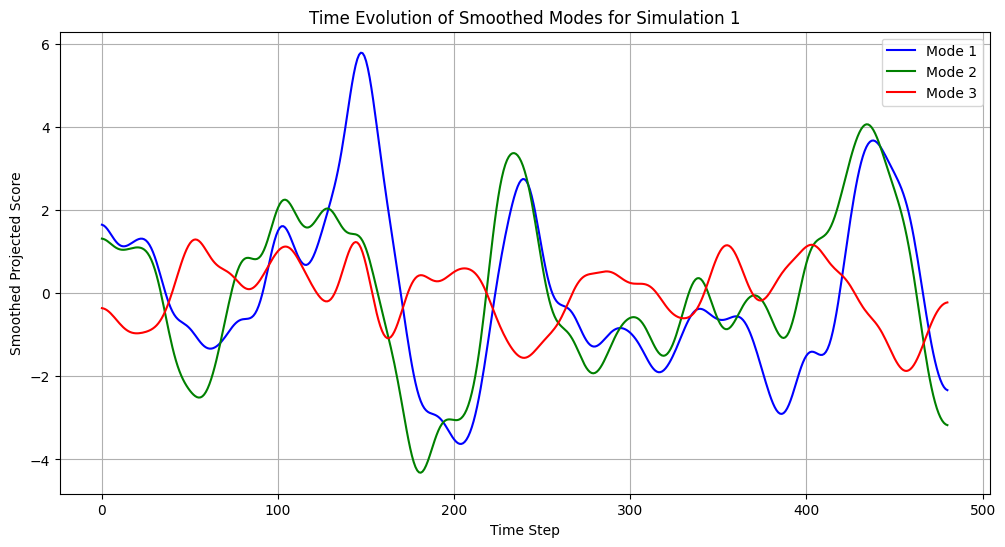

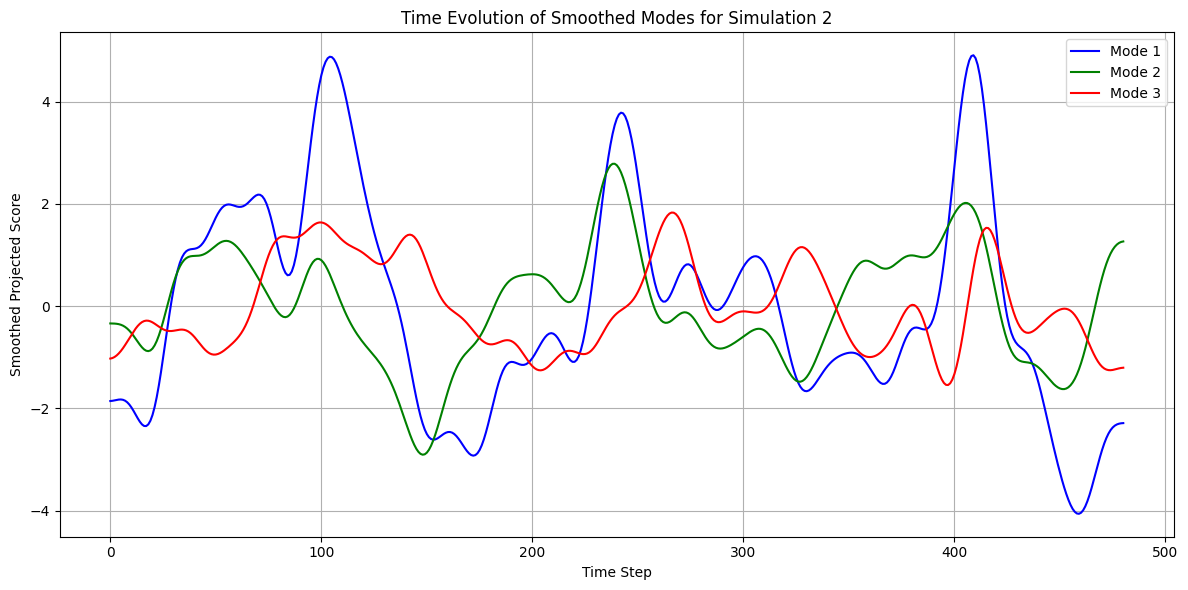

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Number of PCA components
n_components = 3
# Smoothing parameter (sigma for Gaussian filter)
smoothing_sigma = 8
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Define different colors for each mode

# Loop over simulations
for i_simu in tqdm(range(2)):  # Assuming 2 simulations for now
    RHO_W_new = simu_list[i_simu].dataset_isentropic.RHO_W.values

    # Step 1: Replace NaN values with 0 (or another value depending on your preference)
    RHO_W_clean_new = np.nan_to_num(RHO_W_new, nan=0)

    # Step 2: Reshape the data from (nt, n_x, n_y) to (nt, n_x * n_y)
    nt, n_x, n_y = RHO_W_clean_new.shape
    reshaped_RHO_W_new = RHO_W_clean_new.reshape(nt, n_x * n_y)

    # Step 3: Standardize the data (mean = 0, variance = 1)
    scaler = StandardScaler()
    standardized_RHO_W_new = scaler.fit_transform(reshaped_RHO_W_new)

    # Step 4: Project the new data onto the PCA components
    projected_scores = standardized_RHO_W_new.dot(pca.components_.T)  # Shape: (nt, n_components)

    # Step 5: Apply smoothing to the time series using Gaussian filter
    smoothed_scores = gaussian_filter1d(projected_scores, sigma=smoothing_sigma, axis=0)

    # Step 6: Create a new figure for each simulation and plot all modes on the same axes
    fig, ax = plt.subplots(figsize=(12, 6))  # One plot per simulation

    for i in range(n_components):
        ax.plot(smoothed_scores[:, i], label=f'Mode {i + 1}', color=colors[i % len(colors)])
    
    # Customize the plot
    ax.grid(True)
    ax.set_title(f'Time Evolution of Smoothed Modes for Simulation {i_simu + 1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Smoothed Projected Score')
    ax.legend()

# Display all plots
plt.tight_layout()
plt.show()


 ... (more hidden) ...

Explained variance ratio: [0.06680266 0.02313765 0.01774645]
Principal components shape: (3, 3200)


 ... (more hidden) ...

Explained variance ratio: [0.05899255 0.02298389 0.01643585]
Principal components shape: (3, 3200)


 ... (more hidden) ...

Explained variance ratio: [0.05929437 0.0219873  0.01843493]
Principal components shape: (3, 3200)


 ... (more hidden) ...

Explained variance ratio: [0.0714657  0.0436117  0.02132491]
Principal components shape: (3, 3200)


 ... (more hidden) ...

Explained variance ratio: [0.12118351 0.02676741 0.02337822]
Principal components shape: (3, 3200)


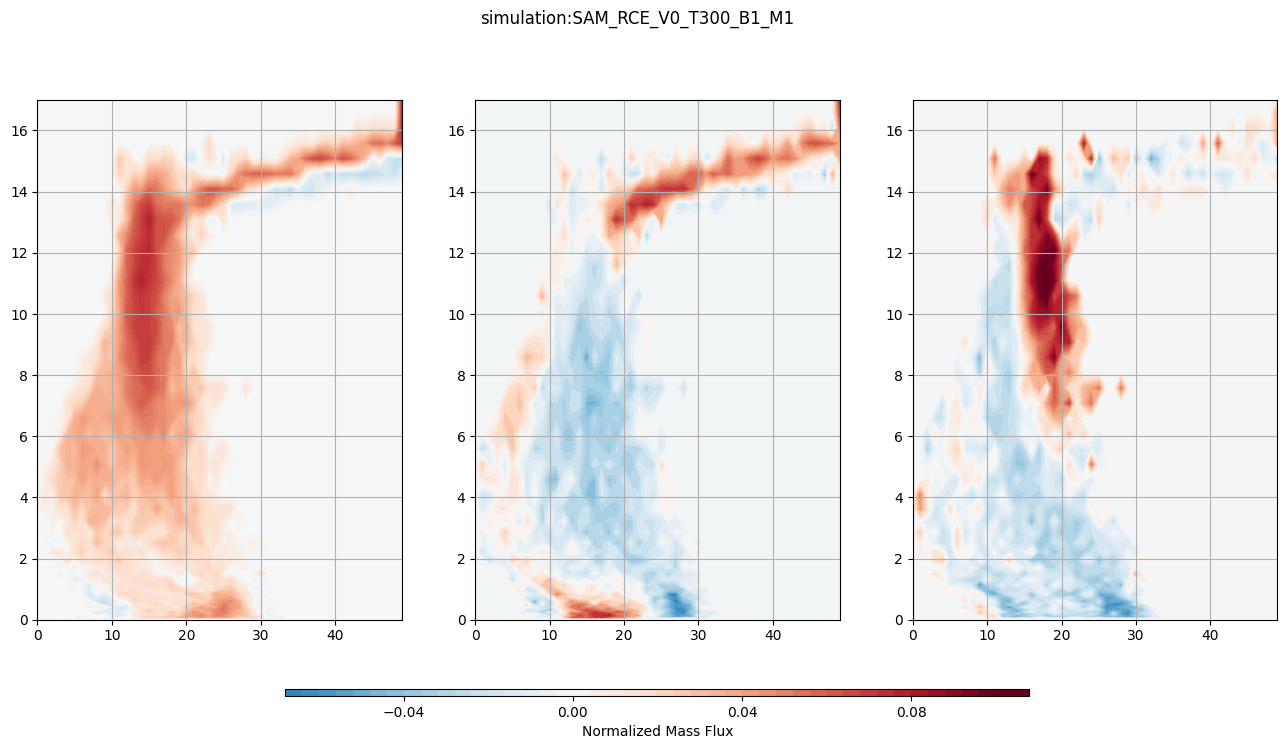

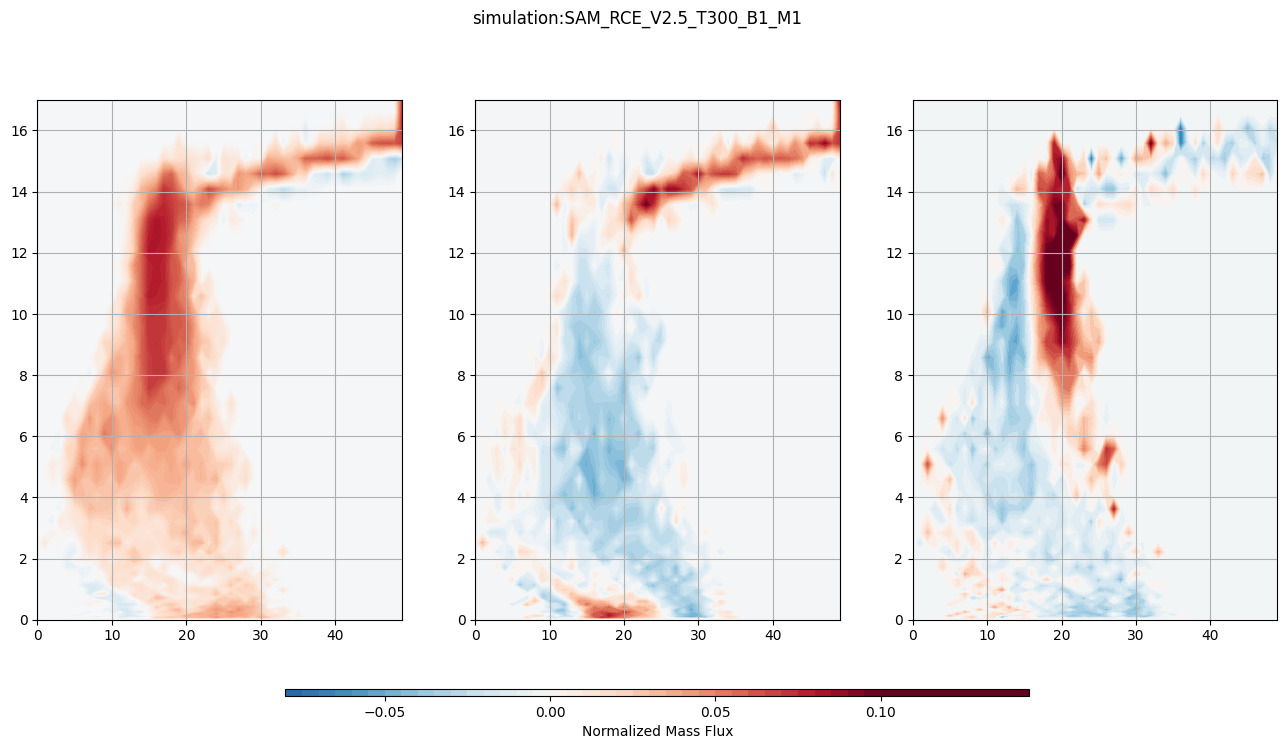

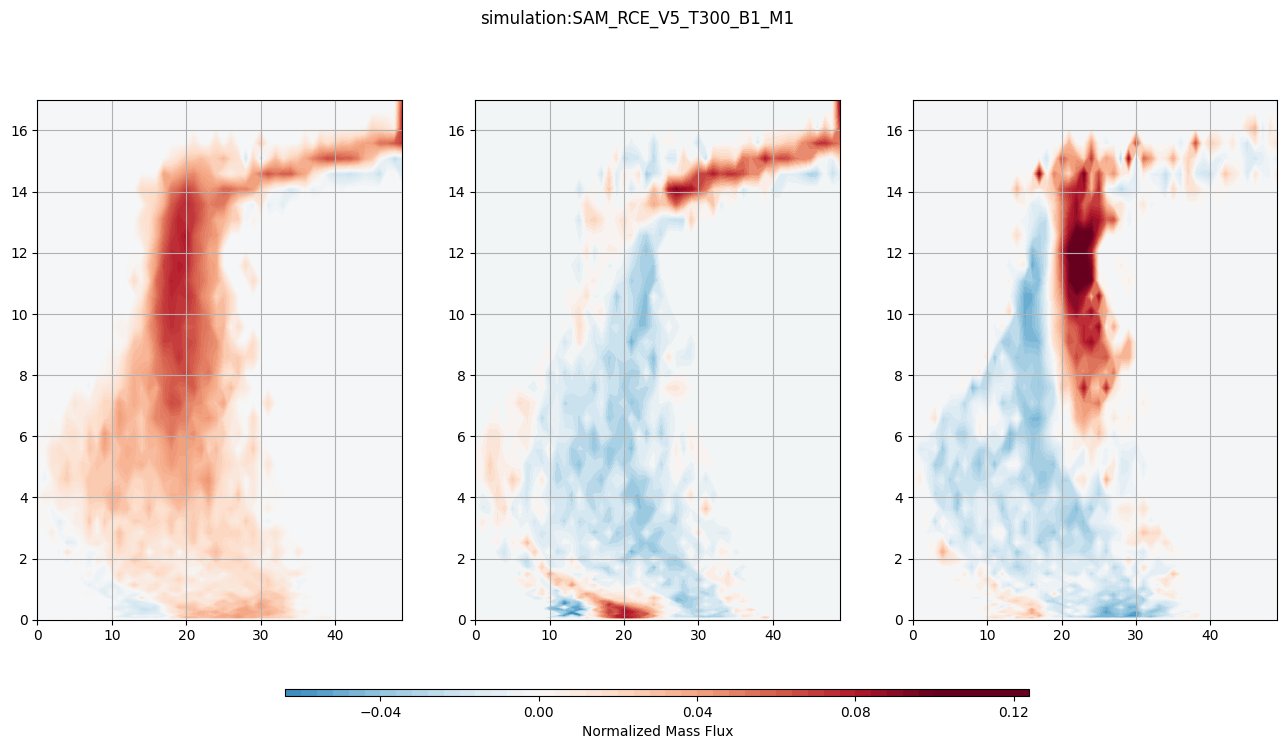

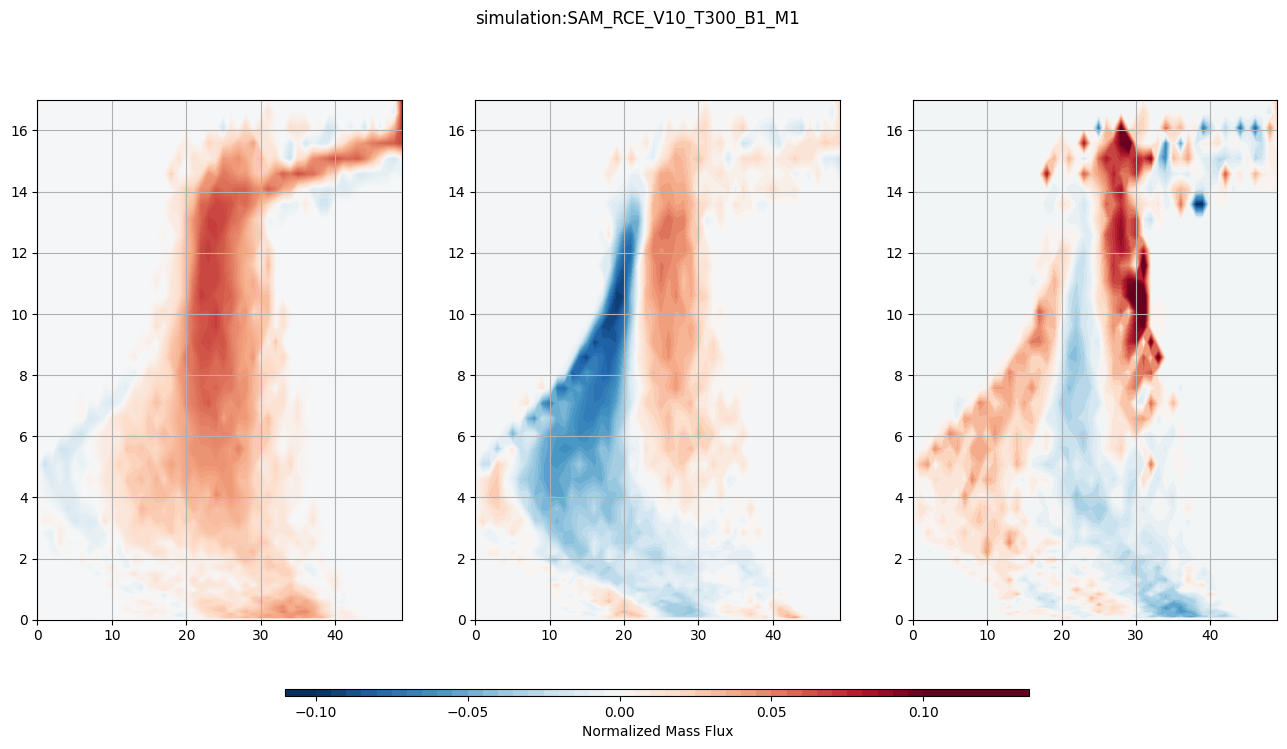

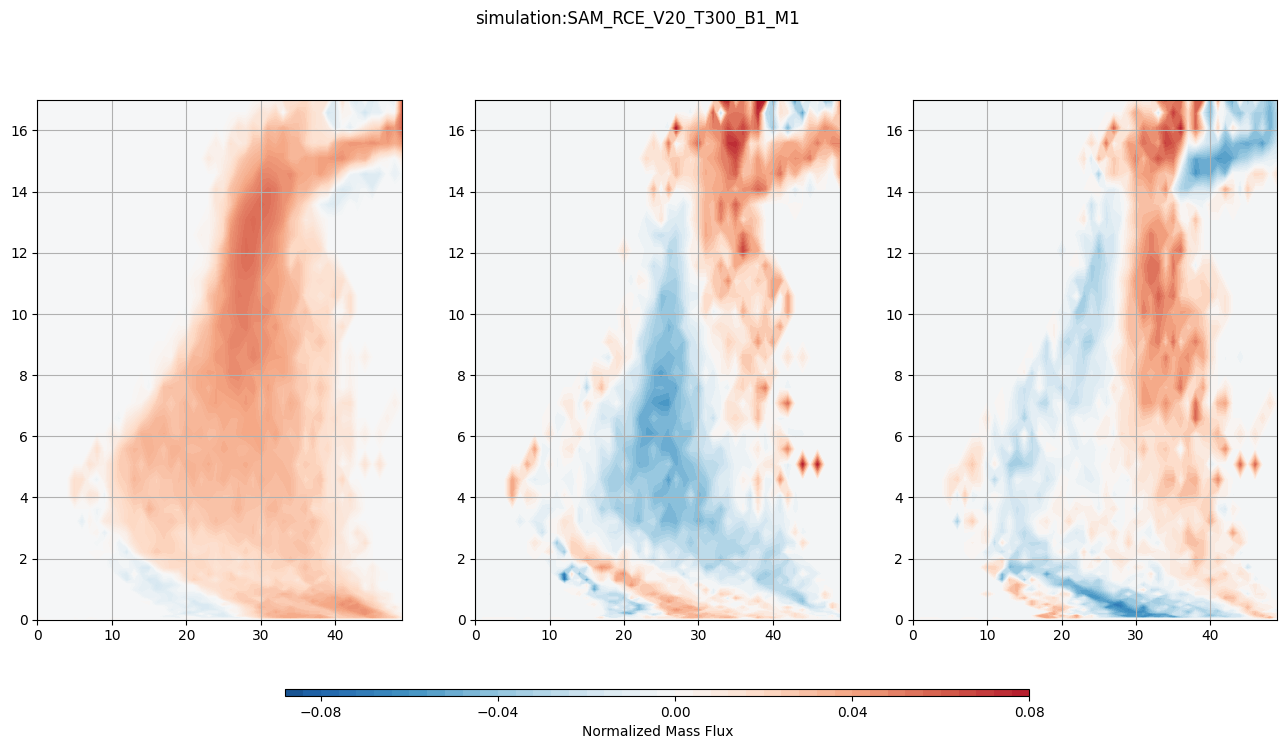

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import ticker

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values/1000
XX,YY = np.meshgrid(fmse, z)

for i_simu in tqdm(range(5)):

    RHO_W = simu_list[i_simu].dataset_isentropic.RHO_W.values

    # Assuming RHO_W is your 3D variable with shape (nt, n_x, n_y)
    # Step 1: Replace NaN values with -10
    RHO_W_clean = np.nan_to_num(RHO_W, nan=0)

    # Step 2: Reshape the data from (nt, n_x, n_y) to (nt, n_x * n_y)
    nt, n_x, n_y = RHO_W_clean.shape
    reshaped_RHO_W = RHO_W_clean.reshape(nt, n_x * n_y)

    # Step 3: Standardize the data (mean = 0, variance = 1)
    scaler = StandardScaler()
    standardized_RHO_W = scaler.fit_transform(reshaped_RHO_W)

    # Step 4: Apply PCA
    n_components = 3  # Set the number of principal components you want to keep
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(standardized_RHO_W)

    # Access PCA results:
    explained_variance_ratio = pca.explained_variance_ratio_
    principal_components = pca.components_

    # Outputs:
    print("Explained variance ratio:", explained_variance_ratio)
    print("Principal components shape:", principal_components.shape)

    fig, ax = plt.subplots(1,n_components, figsize=(16,9))
    # Step 5: Visualize the spatial modes (only for valid points)
    for i in range(n_components):
        # Create an empty grid and fill valid points
        #spatial_mode = np.zeros((n_x, n_y))*np.nan
        spatial_mode = pca.components_[i].reshape(n_x, n_y)

        #print(np.min(pca.components_[i]), print(np.max(pca.components_[i])))


        im = ax[i].contourf(XX,YY, spatial_mode, 50, cmap='RdBu_r', vmin=-0.1,vmax = 0.1 )
        ax[i].grid(True)

        #ax[i].set_title(f'explained variance: {pca.explained_variance_ratio_[i]}')
        ax[i].set_ylim(0,17)

    fig.suptitle(f'simulation:{simu_list[i_simu].name}')
    cb = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.6, aspect=110, pad=0.1, label='Normalized Mass Flux')
    #cb = plt.colorbar(im, shrink=0.6, orientation='horizontal')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()

        #plt.show()

 ... (more hidden) ...


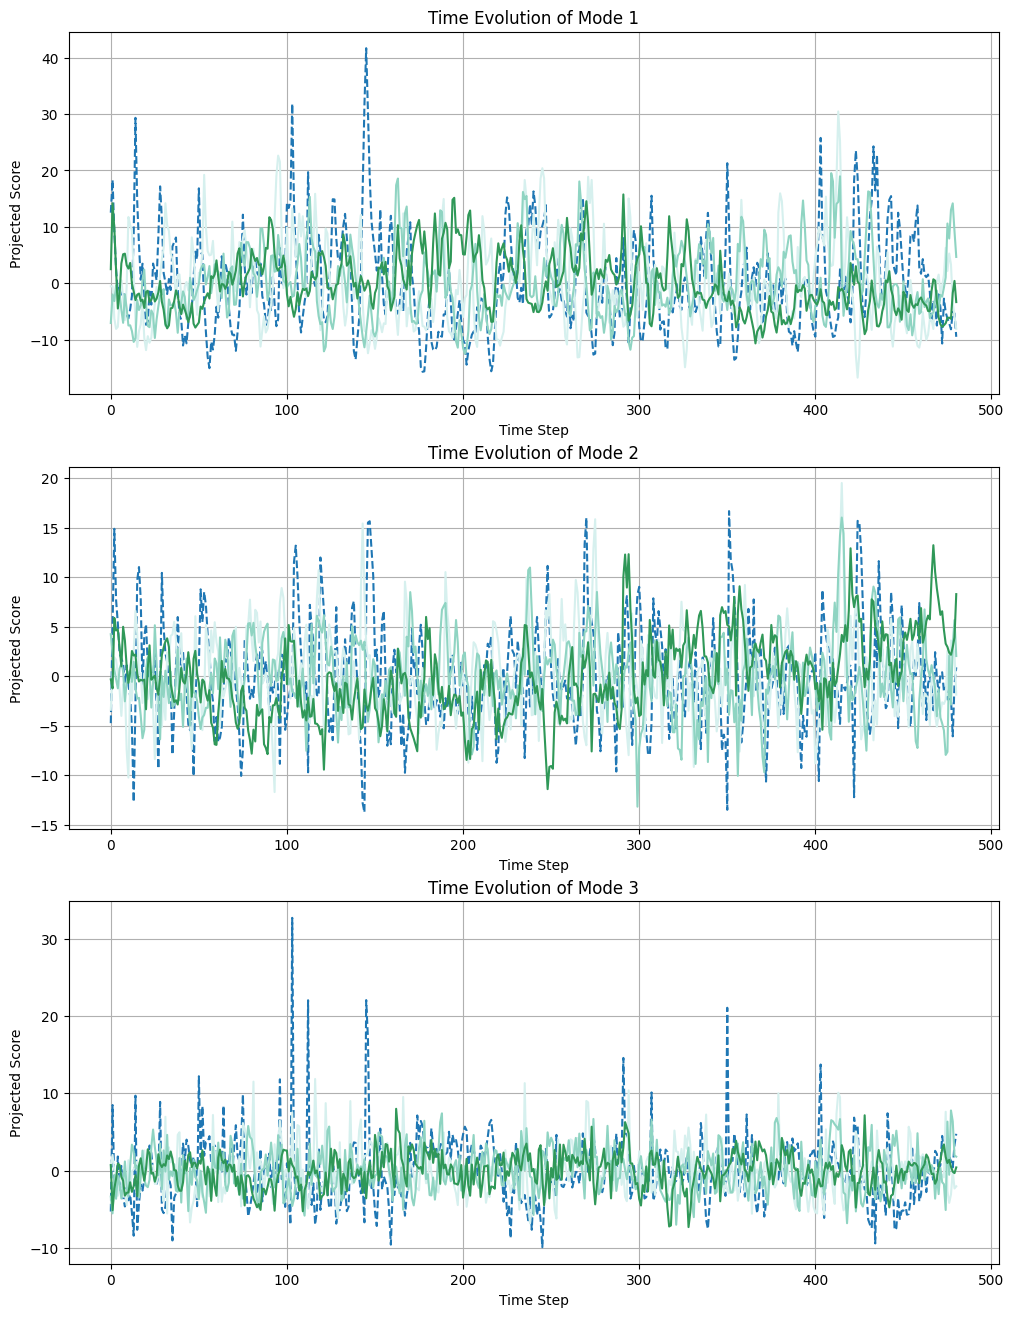

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots(3,1, figsize=(12, 16))
for i in range(n_components):

    #ax[i].hist(pca_result[:, i], label=f'Mode {i + 1}', color=simu_list[0].color, ls='--', bins=50)  # Plot scores over time
    ax[i].plot(pca_result_control[:, i], label=f'Mode {i + 1}', color=simu_list[0].color, ls='--')  # Plot scores over time


#for i_simu in tqdm(range(1,len(simu_list))):
for i_simu in tqdm(range(1,4)):
    RHO_W_new = simu_list[i_simu].dataset_isentropic.RHO_W.values

    # Assuming RHO_W is your 3D variable with shape (nt, n_x, n_y)
    # Step 1: Replace NaN values with -10
    RHO_W_clean_new = np.nan_to_num(RHO_W_new, nan=0)

    # Step 2: Reshape the data from (nt, n_x, n_y) to (nt, n_x * n_y)
    nt, n_x, n_y = RHO_W_clean_new.shape
    reshaped_RHO_W_new = RHO_W_clean_new.reshape(nt, n_x * n_y)

    # Step 3: Standardize the data (mean = 0, variance = 1)
    scaler = StandardScaler()
    standardized_RHO_W_new = scaler.fit_transform(reshaped_RHO_W_new)




    # Step 3: Project the new data onto the PCA components from the previous analysis
    # Assuming 'pca.components_' holds the spatial modes from the original PCA
    # pca.components_.shape should be (n_components, n_x * n_y)
    projected_scores = standardized_RHO_W_new.dot(pca_control.components_.T)  # Shape: (nt_new, n_components)

    # Step 4: Plot the time evolution of the new data projected onto the old modes
    import matplotlib.pyplot as plt

    n_components = projected_scores.shape[1]  # Number of PCA components

    
    for i in range(n_components):
        ax[i].plot(projected_scores[:, i], label=f'Mode {i + 1}', color=simu_list[i_simu].color)
        #ax[i].hist(projected_scores[:, i], label=f'Mode {i + 1}', color=simu_list[i_simu].color, alpha=0.6, bins=30)
        ax[i].grid()
        #ax[i].plot(pca_result[:, i], label=f'Mode {i + 1}', color=simu_list[0].color, ls='--')  # Plot scores over time

        ax[i].set_title(f'Time Evolution of Mode {i + 1}')
        ax[i].set_xlabel('Time Step')
        ax[i].set_ylabel('Projected Score')

#ax[0].set_ylim(-10,10)
#ax[1].set_ylim(-10,10)
#ax[2].set_ylim(-10,10)
#ax[i].legend()



In [11]:
import cmocean

 ... (more hidden) ...

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


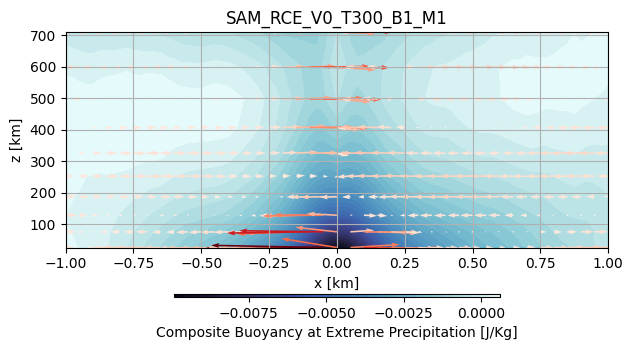

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


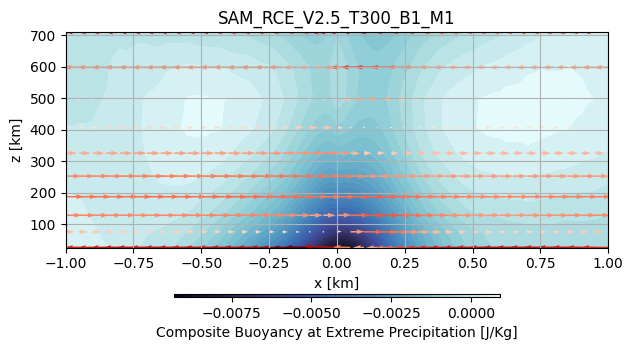

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


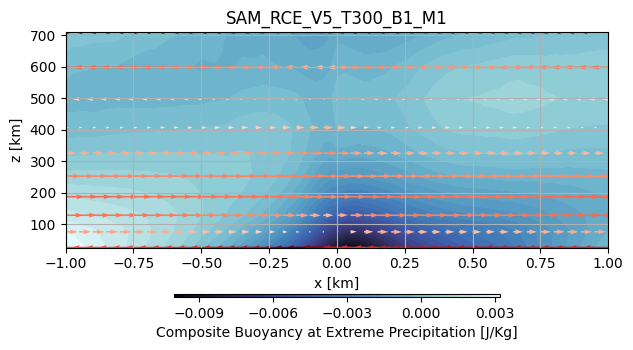

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


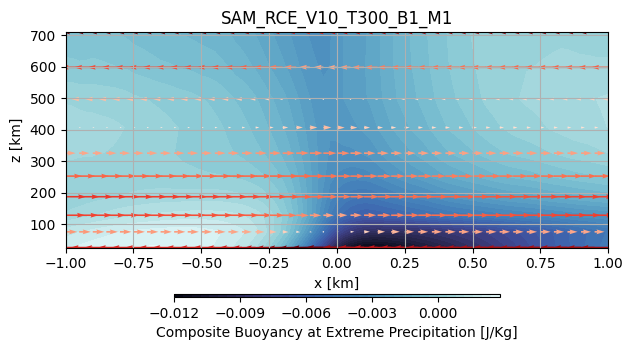

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


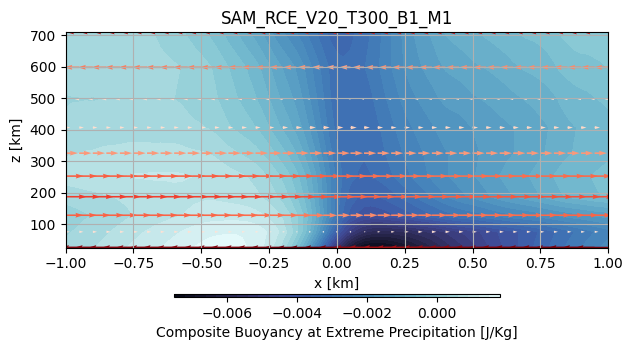

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


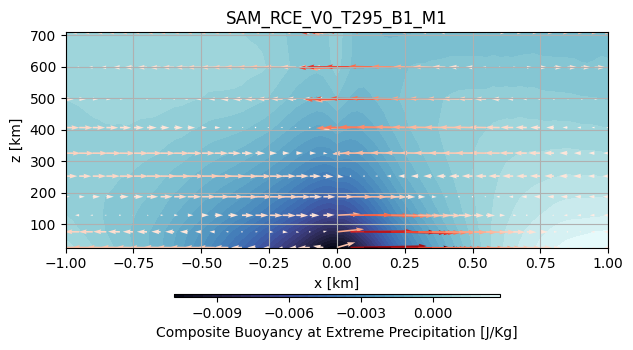

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


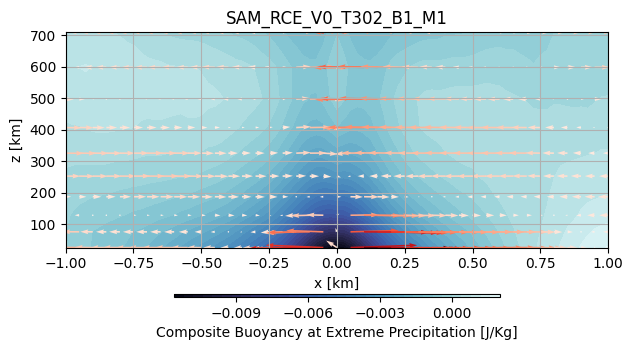

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


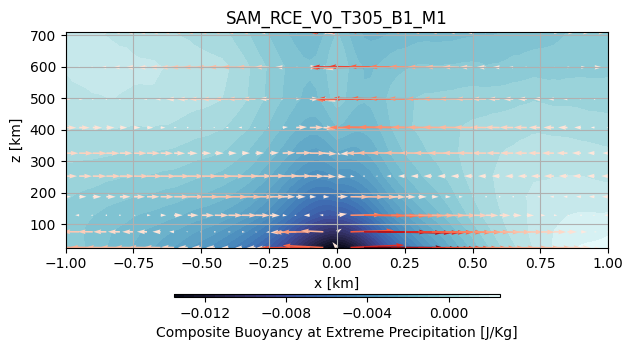

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


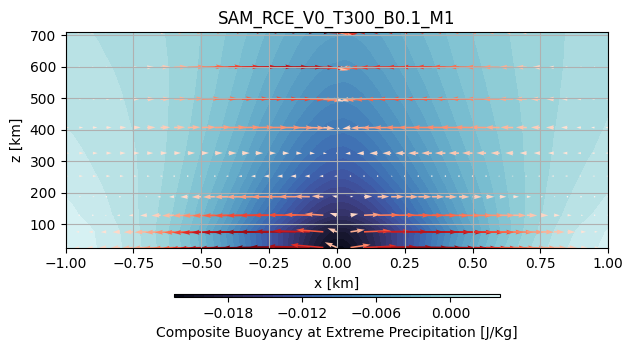

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


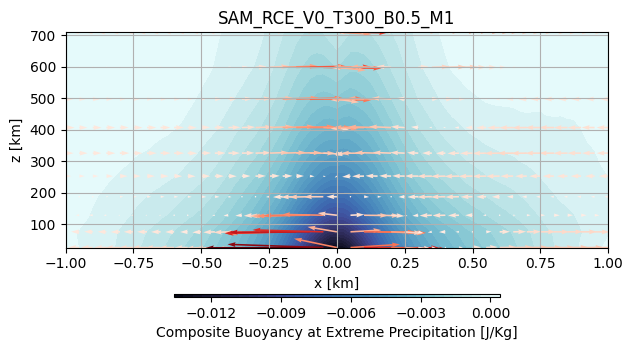

 ... (more hidden) ...


In [12]:
for simu in tqdm(simu_list):
    simu.set_composite_variables(data_name='BUOYANCY', 
                                variable_to_look_for_extreme='Prec', 
                                extreme_events_choice='max', 
                                x_margin=40,
                                y_margin=40,
                                dataset_for_variable_2d='dataset_2d',
                                dataset_for_variable_3d='dataset_computed_3d')
                                
    simu.set_composite_variables(data_name='U', 
                                variable_to_look_for_extreme='Prec', 
                                extreme_events_choice='max', 
                                x_margin=40,
                                y_margin=40,
                                dataset_for_variable_2d='dataset_2d',
                                dataset_for_variable_3d='dataset_3d')

    simu.set_composite_variables(data_name='W', 
                                variable_to_look_for_extreme='Prec', 
                                extreme_events_choice='max', 
                                x_margin=40,
                                y_margin=40,
                                dataset_for_variable_2d='dataset_2d',
                                dataset_for_variable_3d='dataset_3d')
    plt.figure(figsize=(7,4))

    XX, ZZ = np.meshgrid(np.linspace(-1,1,81),simu.dataset_3d.z.values)
    im = plt.contourf(XX[:10,:], ZZ[:10,:], np.mean(simu.BUOYANCY_composite_Prec[:10,:,:], axis=1), 35, cmap=cmocean.cm.ice)

    UU = np.mean(simu.U_composite_Prec[:10,:,:], axis=1)[:,::2] - np.mean(np.mean(simu.U_composite_Prec[:10,:,:], axis=1)[:,::2], axis=0)
    WW = np.mean(simu.W_composite_Prec[:10,:,:], axis=1)[:,::2] - np.mean(np.mean(simu.W_composite_Prec[:10,:,:], axis=1)[:,::2], axis=0)

    norm = np.sqrt(UU**2 +WW**2)
    im2 = plt.quiver(XX[:10,:][:,::2], ZZ[:10,:][:,::2], UU, WW, [norm], cmap='Reds')
    
    cb = plt.colorbar(im, orientation='horizontal', aspect=110, shrink=0.6, label='Composite Buoyancy at Extreme Precipitation [J/Kg]')
    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.xlabel('x [km]')
    plt.ylabel('z [km]')
    plt.grid(True)
    plt.title(f'{simu.name}')
    plt.show()


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

fmse, z = simu_list[0].dataset_isentropic.fmse.values, simu_list[0].dataset_3d.z.values / 1000
XX, YY = np.meshgrid(fmse, z)

RHO_W = simu_list[0].dataset_isentropic.RHO_W.values

# Assuming RHO_W is your 3D variable with shape (nt, n_x, n_y)
# Step 1: Replace NaN values with 0 (or other values)
RHO_W_clean = np.nan_to_num(RHO_W, nan=0)

# Step 2: Reshape the data from (nt, n_x, n_y) to (nt, n_x * n_y)
nt, n_x, n_y = RHO_W_clean.shape
reshaped_RHO_W = RHO_W_clean.reshape(nt, n_x * n_y)

# Step 3: Standardize the data (mean = 0, variance = 1)
scaler = StandardScaler()
standardized_RHO_W = scaler.fit_transform(reshaped_RHO_W)

# Step 4: Apply t-SNE
n_components = 2  # t-SNE typically works best with 2 or 3 components
tsne = TSNE(n_components=n_components, random_state=42)
tsne_result = tsne.fit_transform(standardized_RHO_W)

"""
# Step 5: Visualize the t-SNE results
fig, ax = plt.subplots(1, n_components, figsize=(16, 9))
for i in range(n_components):
    # Create an empty grid and fill valid points
    spatial_mode = tsne_result[:, i].reshape(n_x, n_y)

    im = ax[i].contourf(XX, YY, spatial_mode, 50, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    ax[i].grid(True)
    ax[i].set_ylim(0, 17)

fig.suptitle(f'simulation: {simu_list[0].name}')
cb = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.6, aspect=110, pad=0.1, label='t-SNE Output')
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()

# plt.show()
"""

"\n# Step 5: Visualize the t-SNE results\nfig, ax = plt.subplots(1, n_components, figsize=(16, 9))\nfor i in range(n_components):\n    # Create an empty grid and fill valid points\n    spatial_mode = tsne_result[:, i].reshape(n_x, n_y)\n\n    im = ax[i].contourf(XX, YY, spatial_mode, 50, cmap='RdBu_r', vmin=-0.1, vmax=0.1)\n    ax[i].grid(True)\n    ax[i].set_ylim(0, 17)\n\nfig.suptitle(f'simulation: {simu_list[0].name}')\ncb = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.6, aspect=110, pad=0.1, label='t-SNE Output')\ntick_locator = ticker.MaxNLocator(nbins=5)\ncb.locator = tick_locator\ncb.update_ticks()\n\n# plt.show()\n"

In [8]:
tsne_result

array([[ 2.6630495e+00, -3.7851050e+00],
       [ 1.5325086e+00, -4.5336089e+00],
       [ 4.0406346e+00, -1.9297416e+00],
       [ 3.5539460e+00, -1.6929833e+00],
       [-1.7264202e+00, -1.8376302e+00],
       [-1.8178688e-01, -1.5415553e+00],
       [-2.4877172e+00, -2.0255418e+00],
       [ 8.2172549e-01, -7.9296094e-01],
       [ 1.3032526e+00, -5.6665260e-01],
       [ 1.0779750e+00, -6.7175430e-01],
       [ 1.3768657e+00,  3.4960840e+00],
       [ 8.9483285e-01, -1.1966720e+00],
       [ 1.2636344e+00, -8.5403681e-01],
       [ 1.4641416e-01, -2.5097420e+00],
       [ 2.7124424e+00, -5.2864604e+00],
       [ 3.9491606e+00, -2.6472414e+00],
       [ 3.2690728e+00, -1.3329682e+00],
       [-1.2940594e+00, -2.4274340e+00],
       [-7.5164312e-01, -3.8982277e+00],
       [ 7.3927075e-01, -8.9841098e-01],
       [-1.3785831e+00,  4.8823565e-01],
       [ 8.8714540e-01,  4.1687055e+00],
       [ 4.1251431e+00,  1.5059859e+00],
       [-2.0366728e+00, -2.0535851e-01],
       [-7.43515

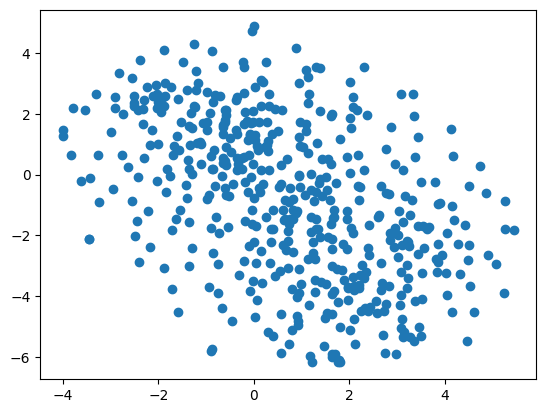

In [9]:
plt.scatter(tsne_result[:,0], tsne_result[:,1])

In [13]:
reshaped_data.shape

(962, 3200)